In [1]:
import bilby
import inspect
%pylab inline

15:53 bilby INFO    : Running bilby version: 0.3.1: (CLEAN) d4c24a0 2018-10-14 23:00:34 -0500


Populating the interactive namespace from numpy and matplotlib


## First we load the data we will analyse, the data is a noisy line with gradient, m = 5 and y intercept, c = 2. 

### the noise is additive:  xerr = 3 + np.random.randn, y = 5 + np.random.randn 

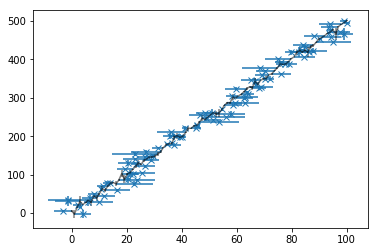

In [2]:
data = np.loadtxt('data.txt')
xobs = data[0,:]
yobs = data[1,:]
xerr = data[2,:]
yerr = data[3,:]
xtrue = np.linspace(0,100, 100)
plt.errorbar(xobs, yobs, xerr = xerr, yerr = yerr, fmt = 'x')
plt.errorbar(xtrue, yobs, yerr = yerr, color = 'black', alpha = 0.5)
plt.show()

In [3]:
#setting up bilby priors
priors = dict(m=bilby.core.prior.Uniform(0, 20, 'm'),
              c=bilby.core.prior.Uniform(0, 20, 'c'))

outdir = 'outdir'
#defining the model function
def model(x, m, c, **kwargs):
    y = m*x + c
    return y

## Our first step is to recover the straight line using a simple Gaussian Likelihood that only takes into account the y errors. Under the assumption we know x exactly. I.E we pass in xtrue

In [4]:
OneDGaussian_knownx = bilby.core.likelihood.GaussianLikelihood(x = xtrue, y = yobs, func = model, sigma = yerr)
result_1D_xtrue = bilby.run_sampler(
    likelihood=OneDGaussian_knownx, priors=priors, sampler='dynesty', npoints=200,
    walks=100, outdir=outdir, label='xtrue_1D_Gaussian')

15:53 bilby INFO    : Search parameters:
15:53 bilby INFO    :   m = Uniform(minimum=0, maximum=20, name='m', latex_label='m', unit=None)
15:53 bilby INFO    :   c = Uniform(minimum=0, maximum=20, name='c', latex_label='c', unit=None)
15:53 bilby INFO    : Single likelihood evaluation took 5.100e-05 s
15:53 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 100, 'update_interval': 120, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c1ded8080>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'pri

15:55 bilby INFO    : Sampling time: 0:01:34.235903
15:55 bilby INFO    : Results saved to outdir/
15:55 bilby INFO    : Summary of results:
nsamples: 3376
log_noise_evidence:    nan
log_evidence: -237.487 +/-  0.249
log_bayes_factor:    nan +/-  0.249



15:55 bilby INFO    : Plotting 1000 draws
15:55 bilby INFO    : Plotting maximum likelihood


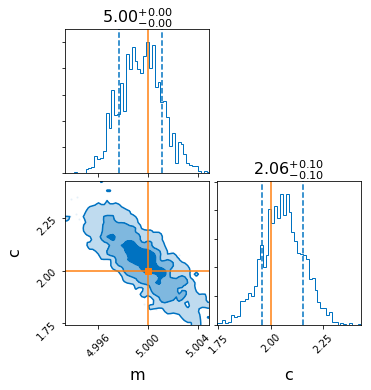

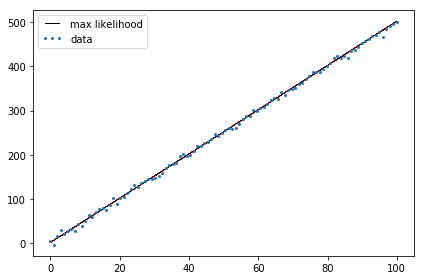

In [5]:
result_1D_xtrue.plot_corner(truth=dict(m=5, c = 2), titles = True)
result_1D_xtrue.plot_with_data(model = model, x = xtrue, y = yobs, ndraws=1000, npoints=100)
plt.show()

## As expected this is easy to recover and the sampler does a good job. However, we made the job too easy by passing in the 'true' values of x. Lets see what happens when we pass in the observed values of x

In [6]:
OneDGaussian_unknownx = bilby.core.likelihood.GaussianLikelihood(x = xobs, y = yobs, func = model, sigma = yerr)
result_1D_xobs = bilby.run_sampler(
    likelihood=OneDGaussian_unknownx, priors=priors, sampler='dynesty', npoints=200,
    walks=100, outdir=outdir, label='xobs_1D_Gaussian')

15:55 bilby INFO    : Search parameters:
15:55 bilby INFO    :   m = Uniform(minimum=0, maximum=20, name='m', latex_label='m', unit=None)
15:55 bilby INFO    :   c = Uniform(minimum=0, maximum=20, name='c', latex_label='c', unit=None)
15:55 bilby INFO    : Single likelihood evaluation took 6.800e-05 s
15:55 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 100, 'update_interval': 120, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c25751668>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'pri

15:57 bilby INFO    : Sampling time: 0:01:37.853129
15:57 bilby INFO    : Results saved to outdir/
15:57 bilby INFO    : Summary of results:
nsamples: 3426
log_noise_evidence:    nan
log_evidence: -27150.076 +/-  0.252
log_bayes_factor:    nan +/-  0.252



15:57 bilby INFO    : Plotting 1000 draws
15:57 bilby INFO    : Plotting maximum likelihood


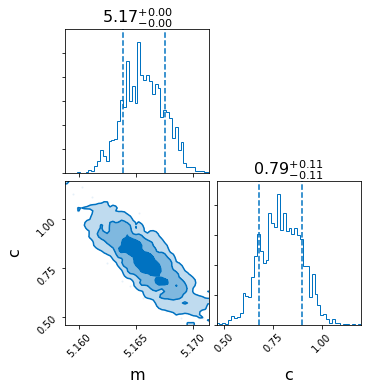

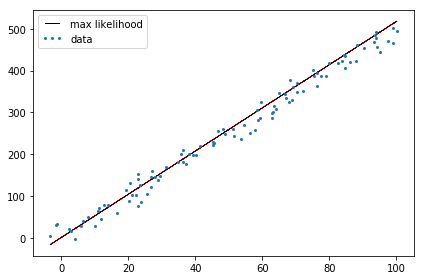

In [7]:
result_1D_xobs.plot_corner(truth=dict(m=5, c = 2), titles = True)
result_1D_xobs.plot_with_data(model = model, x = xobs, y = yobs, ndraws=1000, npoints=100)
plt.show()

## As expected, this is much worse. Let us now define a new likelihood which takes into account x errors but you also pass it in xtrue

In [8]:
class TwoDGaussianLikelihood_knownxtrue(bilby.Likelihood):
    def __init__(self, xtrue, xobs, yobs, xerr, yerr, function):
        """

        Parameters
        ----------
        x, y: array_like
            The data to analyse
        sigma: array_like
            The standard deviation of the noise
        function:
            The python function to fit to the data
        """
        self.xobs = xobs
        self.xtrue = xtrue
        self.yobs = yobs
        self.yerr = yerr
        self.xerr = xerr
        self.function = function
        parameters = inspect.getargspec(function).args
        parameters.pop(0)
        self.parameters = dict.fromkeys(parameters)

    def log_likelihood(self):
        resy = self.yobs - self.function(self.xtrue, **self.parameters)
        resx = self.xobs - self.xtrue
        return -0.5 * (np.sum(((resy) / self.yerr) ** 2) + np.sum(((resx) / self.xerr) ** 2))

In [9]:
TwoDGaussian_knownx = TwoDGaussianLikelihood_knownxtrue(xtrue = xtrue, xobs = xobs, yobs = yobs, xerr=xerr, yerr = yerr, function=model)
result_2D_knownx = bilby.run_sampler(
    likelihood=TwoDGaussian_knownx, priors=priors, sampler='dynesty', npoints=200,
    walks=100, outdir=outdir, label='knownx_2D_Gaussian')

/Users/nsarin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
15:57 bilby INFO    : Search parameters:
15:57 bilby INFO    :   m = Uniform(minimum=0, maximum=20, name='m', latex_label='m', unit=None)
15:57 bilby INFO    :   c = Uniform(minimum=0, maximum=20, name='c', latex_label='c', unit=None)
15:57 bilby INFO    : Single likelihood evaluation took 3.900e-05 s
15:57 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 200, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 100, 'update_interval': 120, 'print_func': 

15:58 bilby INFO    : Sampling time: 0:01:38.567027
15:58 bilby INFO    : Results saved to outdir/
15:58 bilby INFO    : Summary of results:
nsamples: 3374
log_noise_evidence:    nan
log_evidence: -113.270 +/-  0.249
log_bayes_factor:    nan +/-  0.249



15:58 bilby INFO    : Plotting 1000 draws
15:58 bilby INFO    : Plotting maximum likelihood


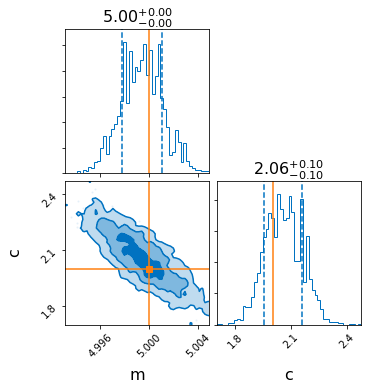

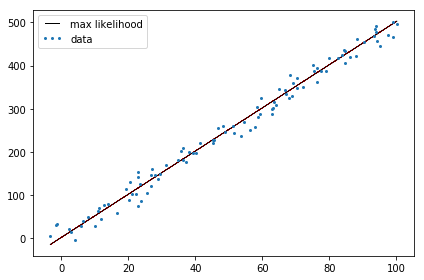

In [10]:
result_2D_knownx.plot_corner(truth=dict(m=5, c = 2), titles = True)
result_2D_knownx.plot_with_data(model = model, x = xobs, y = yobs, ndraws=1000, npoints=100)
plt.show()

## This works, however it still is not realistic as one still needs to 'know' the true x values. Getting around this requires marginilisation of the x data itself or sampling over them.

In [11]:
class TwoDGaussianLikelihood_unknownx(bilby.Likelihood):
    def __init__(self, xobs, yobs, xerr, yerr, function):
        #observed_yis, observed_xis, yi_uncertainties, xi_uncertainties
        """

        Parameters
        ----------
        x, y: array_like
            The data to analyse
        sigma: array_like
            The standard deviation of the noise
        function:
            The python function to fit to the data
        """
        self.xobs = xobs
        self.xtrue = xtrue
        self.yobs = yobs
        self.yerr = yerr
        self.xerr = xerr
        self.function = function
        parameters = inspect.getargspec(function).args
        parameters.pop(0)
        self.parameters = dict.fromkeys(parameters)

    def log_likelihood(self):
        xy_uncertainties = np.sqrt(self.xerr**2. + self.yerr**2.)
        model_y = self.function(self.xobs, **self.parameters)
        return np.sum(-0.5 * ((self.yobs - model_y) / xy_uncertainties)**2
                       - 0.5*np.log(2*np.pi) - np.log(xy_uncertainties))

In [14]:
TwoDGaussian_unknownx = TwoDGaussianLikelihood_unknownx(xobs = xobs, yobs = yobs, xerr=xerr, yerr = yerr, function=model)
result_2D_unknownx = bilby.run_sampler(
    likelihood=TwoDGaussian_unknownx, priors=priors, sampler='dynesty', npoints=500,
    walks=500, outdir=outdir, label='unknownx_2D_Gaussian')

/Users/nsarin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
16:06 bilby INFO    : Search parameters:
16:06 bilby INFO    :   m = Uniform(minimum=0, maximum=20, name='m', latex_label='m', unit=None)
16:06 bilby INFO    :   c = Uniform(minimum=0, maximum=20, name='c', latex_label='c', unit=None)
16:06 bilby INFO    : Single likelihood evaluation took 5.900e-05 s
16:06 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 2.0, 'facc': 0.5, 'slices': 5, 'walks': 500, 'update_interval': 300, 'print_func': 

16:15 bilby INFO    : Sampling time: 0:09:05.067006
16:15 bilby INFO    : Results saved to outdir/
16:15 bilby INFO    : Summary of results:
nsamples: 6577
log_noise_evidence:    nan
log_evidence: -856.382 +/-  0.133
log_bayes_factor:    nan +/-  0.133



16:15 bilby INFO    : Plotting 1000 draws
16:15 bilby INFO    : Plotting maximum likelihood


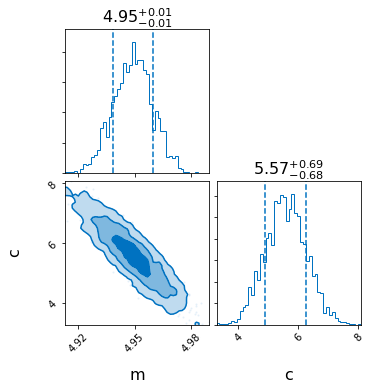

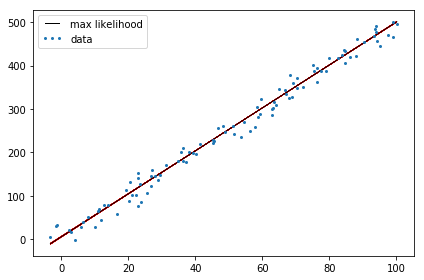

In [15]:
result_2D_unknownx.plot_corner(truth=dict(m=5, c = 2), titles = True)
result_2D_unknownx.plot_with_data(model = model, x = xobs, y = yobs, ndraws=1000, npoints=100)
plt.show()